In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds,load_paths_from_config
from feature_utils import *

In [2]:
compute_features=False

In [3]:
csv_file_path, audio_files_path = load_paths_from_config()


# 1.1) check if the paths exist
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"

In [4]:
# 2) Load metadata
df = load_metadata(csv_file_path)

print(df)
print("Missing values:\n", df.isnull().sum()) # Check for missing values
print(df.describe()) # Show summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

In [5]:
# 3) Define categories
categories = {
        'Animals': ['dog', 'rooster'],
        'Natural soundscapes & water sounds': ['thunderstorm', 'pouring_water'],
        'Human sounds': ['snoring', 'sneezing'],
        'Interior/domestic sounds': ['clock_alarm', 'vacuum_cleaner'],
        'Exterior/urban noises': ['siren', 'helicopter']
    }

# Filter the dataframe to only include selected categories
selected_classes = sum(categories.values(), [])  # Flatten the dictionary into a list of class names
df_filtered = df[df['category'].isin(selected_classes)]  # Keep only selected categories

class_counts = df_filtered['category'].value_counts()
print("Class counts for selected categories:\n", class_counts)
if all(class_counts == 40):
    print("✅ All classes have 40 rows.")
else:
    print("❌ Some classes do not have 40 rows.")
    print("Classes with insufficient rows:\n", class_counts[class_counts != 40])

# # Plot class distribution of selected categories
# plt.figure(figsize=(10, 5))
# sns.countplot(x=df_filtered['category'])
# plt.xticks(rotation=45)
# plt.title("Class Distribution (Selected Categories)")
# plt.show()

Class counts for selected categories:
 category
dog               40
vacuum_cleaner    40
thunderstorm      40
pouring_water     40
clock_alarm       40
helicopter        40
snoring           40
sneezing          40
rooster           40
siren             40
Name: count, dtype: int64
✅ All classes have 40 rows.


In [6]:
# Create a mapping dictionary from category to its target number
category_to_target = df_filtered.set_index('category')['target'].to_dict()
mapping_df = pd.DataFrame(category_to_target.items(), columns=['Category', 'Target'])
print(mapping_df.to_string(index=False))

      Category  Target
           dog       0
vacuum_cleaner      36
  thunderstorm      19
 pouring_water      17
   clock_alarm      37
    helicopter      40
       snoring      28
      sneezing      21
       rooster       1
         siren      42


In [7]:
# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# Track missing and represented classes
missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    # Extract actual classes from sampled sounds
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Check which classes are missing
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")


Category: Animals, Sampled Classes: {'dog', 'rooster'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'pouring_water', 'thunderstorm'}
Category: Human sounds, Sampled Classes: {'snoring', 'sneezing'}
Category: Interior/domestic sounds, Sampled Classes: {'vacuum_cleaner', 'clock_alarm'}
Category: Exterior/urban noises, Sampled Classes: {'siren', 'helicopter'}

✅ Represented Classes:
- Animals: {'dog', 'rooster'}
- Natural soundscapes & water sounds: {'pouring_water', 'thunderstorm'}
- Human sounds: {'snoring', 'sneezing'}
- Interior/domestic sounds: {'vacuum_cleaner', 'clock_alarm'}
- Exterior/urban noises: {'siren', 'helicopter'}

🎉 All expected classes are present!


In [8]:
# 5) Load wave data
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path) #load all sounds

print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


In [9]:
# 7) Extract all features
# keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)

In [10]:
# # 8) Save all features
# save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_combined.npz")

# # Check file integrity after saving
# loaded_data = np.load("features/extracted_features_combined.npz")
# print("Loaded feature shape:", loaded_data['features'].shape)
# print("Keys shape:", loaded_data['keys'].shape)

In [11]:


if compute_features:
    # 7) Extract selected features
    keys_list, mfcc_list, hist_list, spectral_list, zcr_list, envelope_list, hnr_list = compute_features_for_wave_list(wave_list_data)

    # 8) Save selected features
    save_multiple_features_to_npz(
        keys_list, 
        mfcc_list, 
        hist_list, 
        spectral_list, 
        zcr_list, 
        envelope_list, 
        hnr_list, 
        out_file="features/extracted_features_multiple_test.npz"
    )

In [12]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display the shapes of each feature type
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']


# Display first feature vectors for verification
# print("First MFCC feature vector:", loaded_data['mfcc'][0])
# print("First histogram feature vector:", loaded_data['hist'][0])
# print("First spectral feature vector:", loaded_data['spectral'][0])
# print("First ZCR feature vector:", loaded_data['zcr'][0])
# print("First Amplitude Envelope feature vector:", loaded_data['envelope'][0])
# print("First HNR feature vector:", loaded_data['hnr'][0])

# Define feature combinations
feature_combinations = {
    'mfcc': mfcc_features,
    'spectral': spectral_features,
    'hist': hist_features,
    'zcr': zcr_features,
    'envelope': envelope_features,
    'hnr': hnr_features
}

# Combine features based on flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)
print("\nCombined features shape:", combined_features.shape)

Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅
Combined feature shape: (400, 134)

Combined features shape: (400, 134)


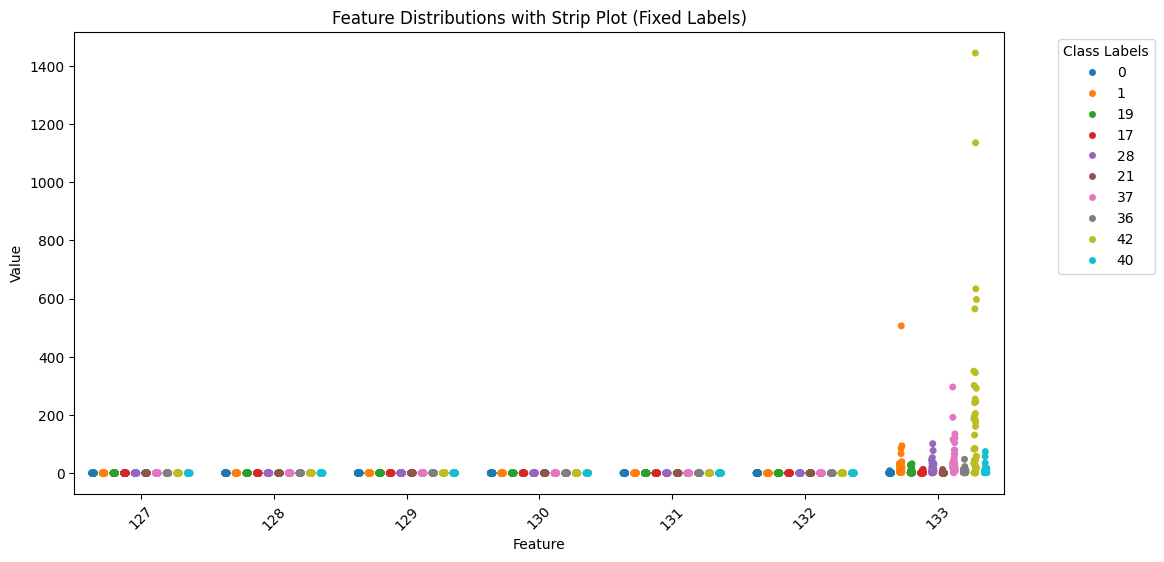

In [13]:
### Compare feature distributions for different classes

# Convert combined_features to DataFrame
df_features = pd.DataFrame(combined_features)
df_features["label"] = keys_list  # Add class labels

# Ensure labels are categorical, not just numbers
df_features["label"] = df_features["label"].astype(str)  # Convert to string labels

# Select first 5 features for visualization (modify if needed)
selected_features = df_features.iloc[:, -8:]  
selected_features["label"] = df_features["label"]  # Re-add labels

# Convert to long format for plotting
df_melted = selected_features.melt(id_vars="label", var_name="Feature", value_name="Value")

# --- Strip Plot Fix ---
plt.figure(figsize=(12, 6))
sns.stripplot(x="Feature", y="Value", hue="label", data=df_melted, dodge=True, jitter=True)
plt.title("Feature Distributions with Strip Plot (Fixed Labels)")
plt.xticks(rotation=45)
plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Fix legend
plt.show()



In [14]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Train-test split
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=keys_list
)


In [15]:
# Normalize the data using Z-score normalization (StandardScaler)
scaler = StandardScaler()

# feature normalization:
# feature = feature - mean(feature acrocss all examples) / std(feature across all examples)
## VERY IMPORTANT: the above mean and std must be calcualted from TRAIN data only, not from EVAL or TEST data

# Fit only on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on train data only
X_test = scaler.transform(X_test_not_scaled)        # Use train's mean and std to scale test data

In [16]:
# Print sizes of train and test sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Debugging - Check which classes exist before and after splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count occurrences of each class in train and test sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Print class counts for debugging purposes
print("\nTraining Class Counts:\n", train_counts)
print("\nTest Class Counts:\n", test_counts)

Training set size: (320, 134)
Test set size: (80, 134)
Unique classes in dataset before splitting: {0, 1, 36, 37, 40, 42, 17, 19, 21, 28}

Training Class Counts:
 0     32
1     32
17    32
19    32
21    32
28    32
36    32
37    32
40    32
42    32
Name: count, dtype: int64

Test Class Counts:
 0     8
1     8
17    8
19    8
21    8
28    8
36    8
37    8
40    8
42    8
Name: count, dtype: int64


In [17]:
# Convert lists to Pandas Series for counting
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge train and test counts into a single DataFrame
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0).astype(int)

# Display the counts table with a better format
print("\nClass Distribution Table:")
print(df_counts.to_string())

# Display summary
print("\nSummary:")
print(f"Total samples in Train set: {df_counts['Train'].sum()}")
print(f"Total samples in Test set: {df_counts['Test'].sum()}")



Class Distribution Table:
    Train  Test
0      32     8
1      32     8
17     32     8
19     32     8
21     32     8
28     32     8
36     32     8
37     32     8
40     32     8
42     32     8

Summary:
Total samples in Train set: 320
Total samples in Test set: 80


In [18]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf','linear']
}

grid_search_svm, best_params_svm, best_score_svm = grid_search_hyperparameter_tuning(
    model=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    X_train=X_train,
    y_train=y_train
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best roc_auc_ovr Score: 0.9890


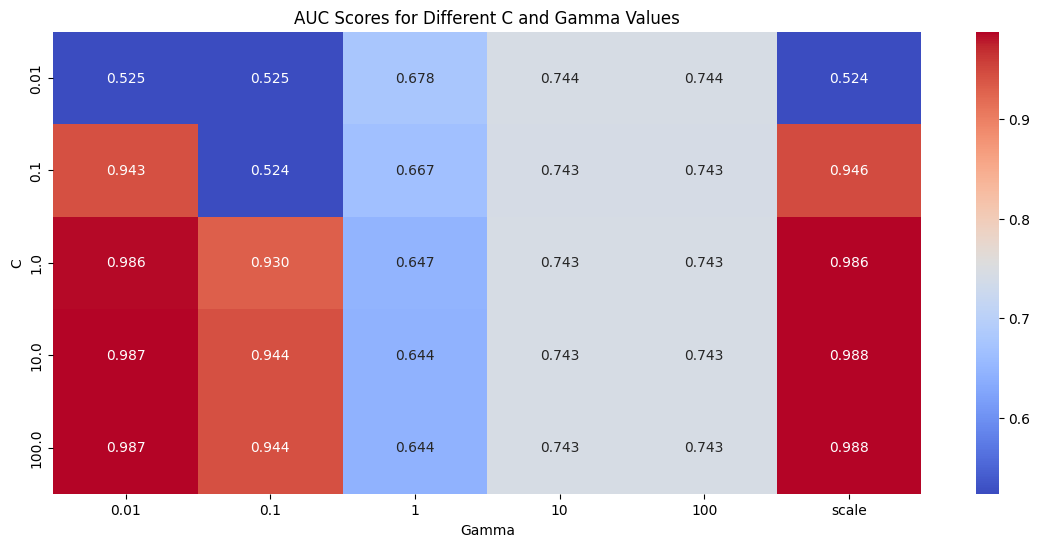

In [19]:
# Convert results to DataFrame
cv_results = pd.DataFrame(grid_search_svm.cv_results_)

# Convert parameters to numeric type for correct sorting
cv_results["param_C"] = cv_results["param_C"].astype(float)
cv_results["param_gamma"] = cv_results["param_gamma"].astype(str)  # Keep gamma as string if 'scale' is used

# Use pivot_table instead of pivot to handle duplicate index-column pairs
df_heatmap = cv_results.pivot_table(index="param_C", columns="param_gamma", values="mean_test_score", aggfunc="mean")

# Sort the index for better visualization
df_heatmap = df_heatmap.sort_index(ascending=True)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("AUC Scores for Different C and Gamma Values")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()



AUC on the test set: 0.9894097222222221

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.88      0.93         8
          17       0.88      0.88      0.88         8
          19       0.64      0.88      0.74         8
          21       0.80      1.00      0.89         8
          28       1.00      0.88      0.93         8
          36       0.89      1.00      0.94         8
          37       0.73      1.00      0.84         8
          40       0.75      0.38      0.50         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.84        80
weighted avg       0.87      0.85      0.84        80


Accuracy on the test set: 0.85


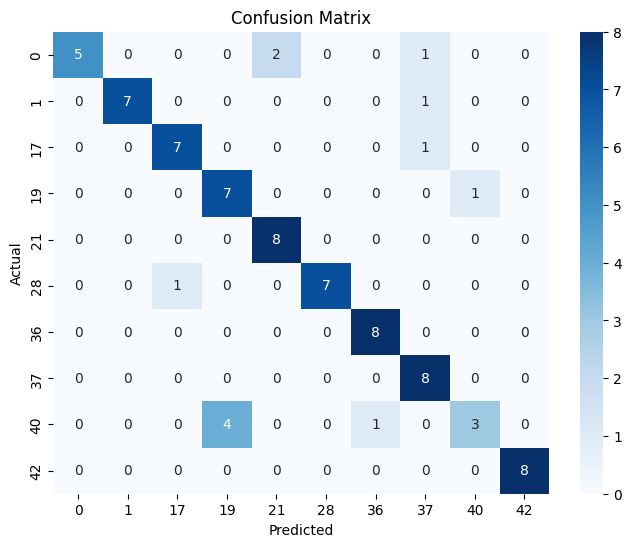

In [20]:
# Initialize the SVM classifier with the best hyperparameters
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)

# Train the SVM classifier on the training set
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)

# Visualize the confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

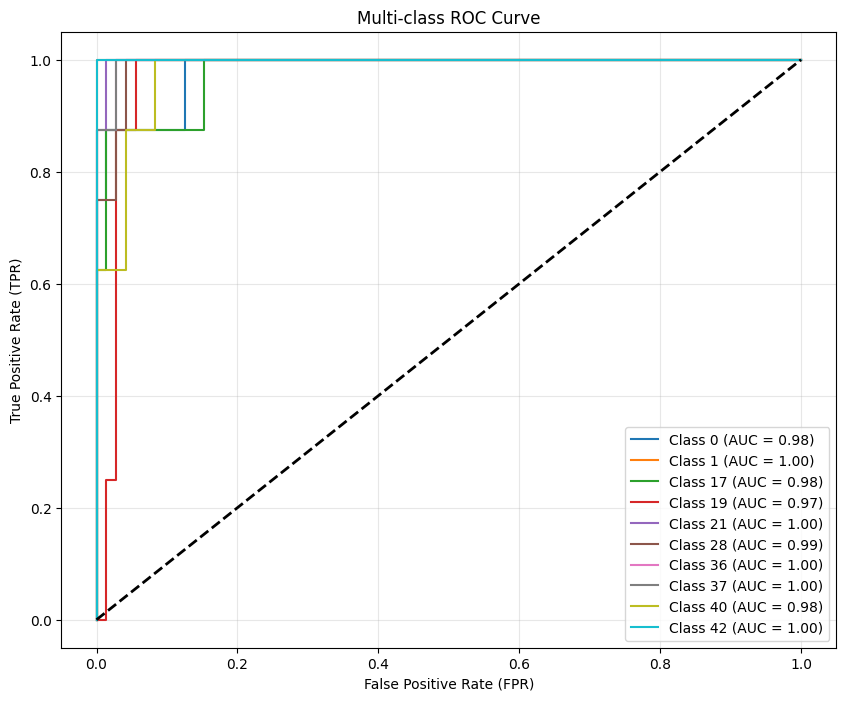

In [21]:
# Binarize the labels for multi-class ROC (One-vs-Rest)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Initialize a plot
plt.figure(figsize=(10, 8))

# Loop through each class and compute ROC curve and AUC
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {np.unique(y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [22]:
# Reduce features to 30 dimensions using PCA
pca = PCA(n_components=0.8)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [0.19509209 0.08515698 0.07228955 0.05691698 0.04521919 0.03602601
 0.03333351 0.03017803 0.02560287 0.02305684 0.02101277 0.01755981
 0.01651567 0.01617374 0.01493781 0.01432483 0.01374819 0.01357472
 0.01244197 0.01181433 0.0112548  0.01099488 0.0103654  0.00963513
 0.0094624 ]
Reduced feature shape: (320, 25)



AUC on the test set: 0.986111111111111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.89      1.00      0.94         8
          17       0.83      0.62      0.71         8
          19       0.64      0.88      0.74         8
          21       0.73      1.00      0.84         8
          28       0.67      0.75      0.71         8
          36       0.88      0.88      0.88         8
          37       1.00      1.00      1.00         8
          40       0.80      0.50      0.62         8
          42       1.00      1.00      1.00         8

    accuracy                           0.82        80
   macro avg       0.84      0.82      0.82        80
weighted avg       0.84      0.82      0.82        80



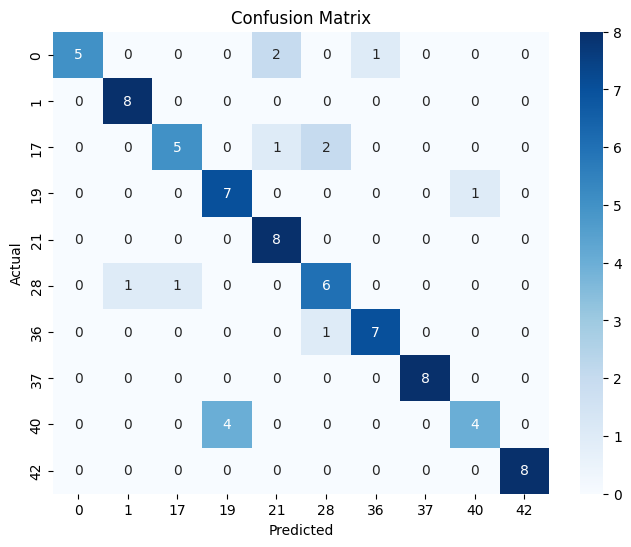

In [23]:
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# Step 3: Evaluate the classifier
y_pred = svm.predict(X_test_pca)
y_prob = svm.predict_proba(X_test_pca)

# Step 4: Calculate metrics
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
results = test_feature_combinations(
    
    combinations_dict=feature_combinations,
    y=y,
    model=SVC(),  # Specify the SVM model
    model_name="SVM",  # Provide a name for display pu,rposes
    model_params={'kernel': 'rbf', 'C': 1, 'gamma': 'scale', 'probability': True, 'random_state': 42},  # Custom SVM parameters
    n_splits=5,  # Number of Stratified K-Folds
    normalize=True,  # Enable normalization of features
    apply_pca=True,  # Apply PCA during feature processing
    n_pca_components=0.9,  # Number of PCA components (explained variance ratio)
    overfit_threshold=0.15,  # Overfitting threshold
    use_gridsearch=False,  # Disable GridSearchCV for now
    hyperparameter_grid={
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.1, 0.01],
        'kernel': ['rbf']
    } if False else None,  # Use direct Boolean instead of undefined variable
    top_k_results=5,  # Display the top 5 combinations
    verbose=False  # Enable detailed output for each combination
)


🔍 Testing 63 feature combinations for SVM...


📊 Top 5 Results (sorted by Combined Score):
  1. Combination: ('mfcc', 'spectral', 'envelope', 'hnr'), Combined Score: 0.9022, Test Acc: 0.8219, Train Acc: 0.9531, AUC: 0.9824, Train-Test Gap: 0.1312, Overfitting Status: ✅ No Overfitting
  2. Combination: ('mfcc', 'spectral', 'zcr', 'envelope', 'hnr'), Combined Score: 0.9007, Test Acc: 0.8187, Train Acc: 0.9539, AUC: 0.9827, Train-Test Gap: 0.1352, Overfitting Status: ✅ No Overfitting
  3. Combination: ('mfcc', 'spectral', 'envelope'), Combined Score: 0.8976, Test Acc: 0.8125, Train Acc: 0.9531, AUC: 0.9828, Train-Test Gap: 0.1406, Overfitting Status: ✅ No Overfitting
  4. Combination: ('mfcc', 'spectral', 'zcr', 'envelope'), Combined Score: 0.8976, Test Acc: 0.8125, Train Acc: 0.9531, AUC: 0.9827, Train-Test Gap: 0.1406, Overfitting Status: ✅ No Overfitting
  5. Combination: ('mfcc', 'spectral', 'hist', 'zcr', 'envelope'), Combined Score: 0.8939, Test Acc: 0.8063, Train Acc: 0.9609, AUC:

In [25]:
top_5_results_length_lim = [res for res in results if len(res['combination']) == 3 and res['overfitting_status'] == "✅ No Overfitting"]
top_5_results_length_lim.sort(key=lambda x: x['combined_score'], reverse=True)

print("\nTop 5 Non-Overfitted Combinations with Exactly 3 Features:")
for res in top_5_results_length_lim[:5]:  # Display the top 5
    print(f"Combination: {res['combination']}, AUC: {res['average_auc']:.4f}, "
          f"Val Accuracy: {res['average_val_accuracy']:.4f}, Overfitting: {res['overfitting_status']}")


Top 5 Non-Overfitted Combinations with Exactly 3 Features:
Combination: ('mfcc', 'spectral', 'envelope'), AUC: 0.9828, Val Accuracy: 0.8125, Overfitting: ✅ No Overfitting
Combination: ('spectral', 'envelope', 'hnr'), AUC: 0.9788, Val Accuracy: 0.7688, Overfitting: ✅ No Overfitting
Combination: ('spectral', 'zcr', 'envelope'), AUC: 0.9781, Val Accuracy: 0.7688, Overfitting: ✅ No Overfitting
Combination: ('spectral', 'zcr', 'hnr'), AUC: 0.9726, Val Accuracy: 0.7219, Overfitting: ✅ No Overfitting
Combination: ('zcr', 'envelope', 'hnr'), AUC: 0.9140, Val Accuracy: 0.5687, Overfitting: ✅ No Overfitting


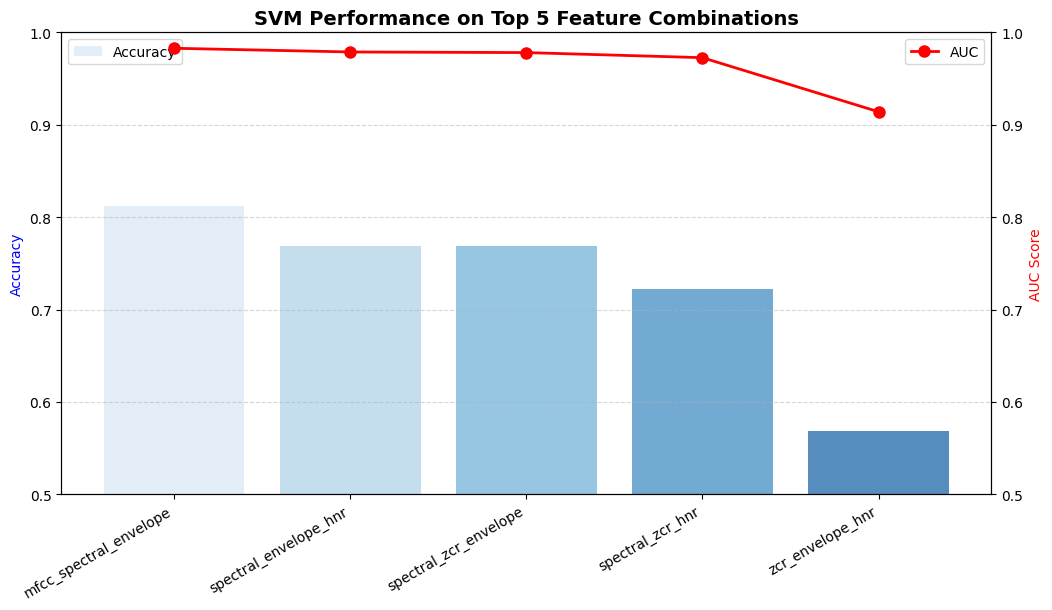

In [26]:
# Extract information from top 5 non-overfitted results
feature_names = ["_".join(res['combination']) for res in top_5_results_length_lim[:5]]
accuracies = [res['average_val_accuracy'] for res in top_5_results_length_lim[:5]]
auc_scores = [res['average_auc'] for res in top_5_results_length_lim[:5]]

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use different colors for bars
colors = sns.color_palette("Blues", len(feature_names))

# Plot Accuracy (Bar chart)
ax1.bar(feature_names, accuracies, color=colors, alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy', color='b')
ax1.set_ylim(0.5, 1.0)  # Set limits to fit the data well

# Rotate X-axis labels for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)

# Add grid lines for better visual separation
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Create a second y-axis for AUC scores
ax2 = ax1.twinx()

# Plot AUC as a red line with markers
ax2.plot(feature_names, auc_scores, color='r', marker='o', linestyle='-', linewidth=2, markersize=8, label='AUC')
ax2.set_ylabel('AUC Score', color='r')
ax2.set_ylim(0.5, 1.0)  # Set limits to fit the data well

# Formatting
plt.title("SVM Performance on Top 5 Feature Combinations", fontsize=14, fontweight='bold')

# Add legends
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Show the plot
plt.show()

In [27]:
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)


Combined feature shape: (400, 54)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 54)



Settings:
 - Selected Features: mfcc, spectral, zcr, envelope, hnr
 - Model: SVC
 - Model Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'random_state': 42}

 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9}


[Fold 1]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 54
   - Train Accuracy: 0.9406, Test Accuracy: 0.8375
   - AUC: 0.9814

[Fold 2]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 54
   - Train Accuracy: 0.9375, Test Accuracy: 0.8875
   - AUC: 0.9939

[Fold 3]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 54
   - Train Accuracy: 0.9375, Test Accuracy: 0.8500
   - AUC: 0.9901

[Fold 4]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 54
   - Train Accuracy: 0.9437, Test Accuracy: 0.8125
   - AUC: 0.9852

[Fold 5]
   - Training set size: 320, Test set size: 80
   -

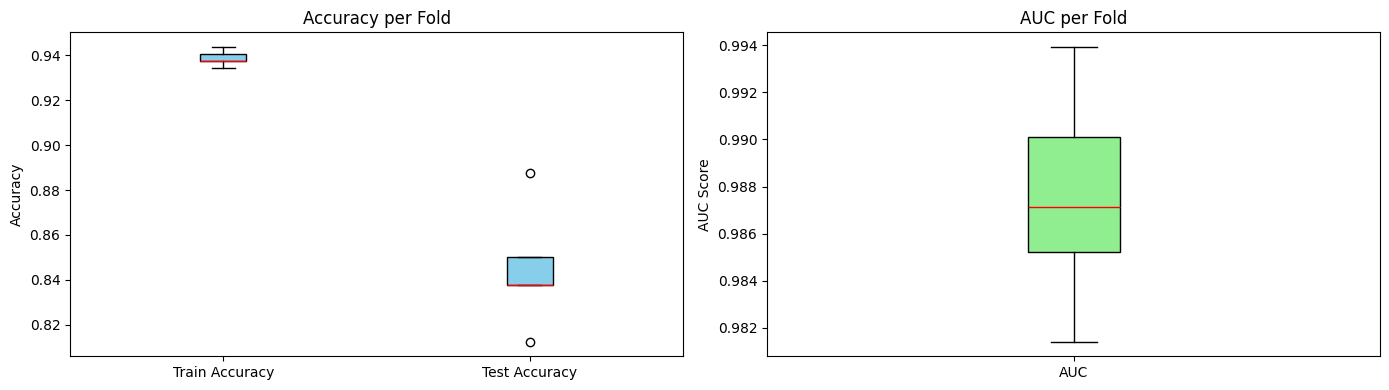


Classification Report (Last Fold):
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      0.88      0.93         8
          17       1.00      0.75      0.86         8
          19       0.80      1.00      0.89         8
          21       0.80      1.00      0.89         8
          28       0.88      0.88      0.88         8
          36       0.78      0.88      0.82         8
          37       0.86      0.75      0.80         8
          40       0.86      0.75      0.80         8
          42       1.00      0.88      0.93         8

    accuracy                           0.84        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.84      0.84        80



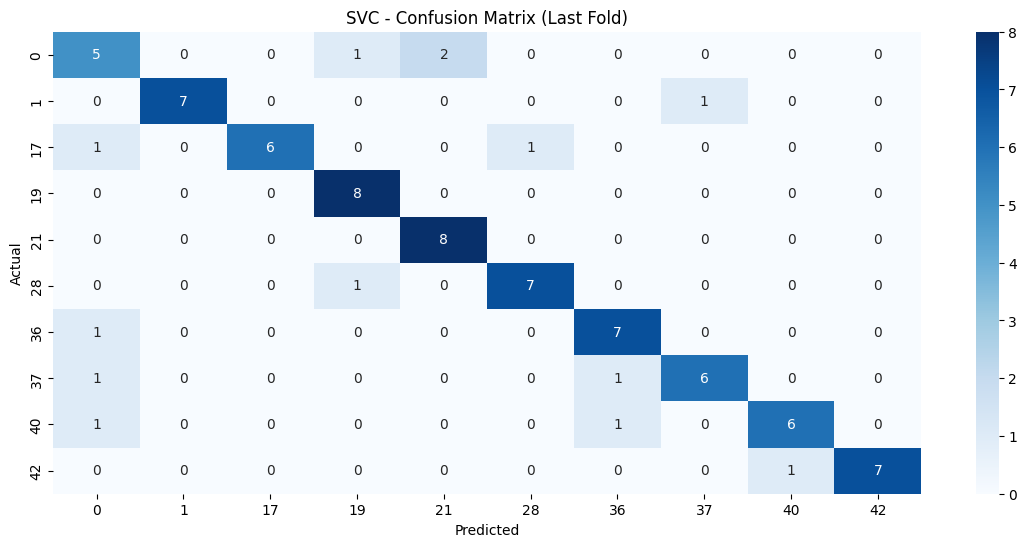

In [28]:
svm_results = kfold_cross_validation(
    features=selected_features,
    labels=y,
    selected_features_names=selected_features_names,
    model=SVC(probability=True),
    model_params={'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'random_state': 42},
    n_splits=5,
    preprocess_params={'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9},
    overfit_threshold=0.1
)

---
---

# RF

In [29]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)


Combined feature shape: (400, 134)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


In [30]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)


Random Forest - AUC on the test set: 0.9928819444444444

Random Forest - Accuracy on the test set: 0.8875

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.89      1.00      0.94         8
          17       0.88      0.88      0.88         8
          19       0.70      0.88      0.78         8
          21       0.89      1.00      0.94         8
          28       1.00      0.75      0.86         8
          36       0.89      1.00      0.94         8
          37       1.00      0.88      0.93         8
          40       0.83      0.62      0.71         8
          42       0.88      0.88      0.88         8

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



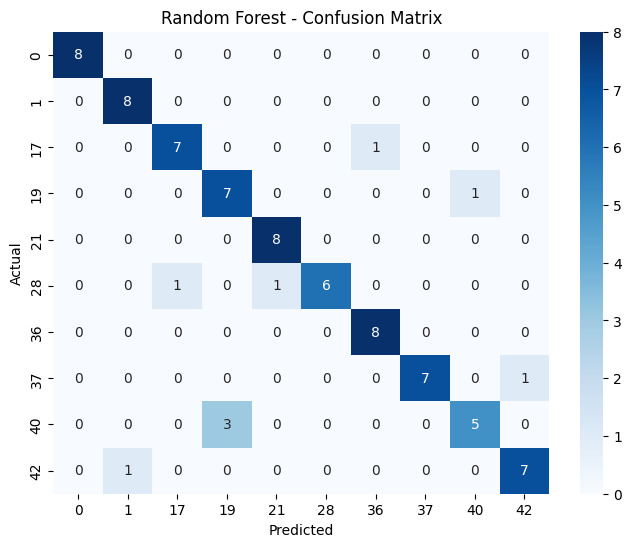

In [31]:
# AUC score
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [32]:
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)


Training Accuracy: 1.0


In [33]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [34]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)


Random Forest - AUC on the test set: 0.9928819444444444

Random Forest - Accuracy on the test set: 0.9125

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      1.00      0.94         8
          17       0.75      0.75      0.75         8
          19       0.80      1.00      0.89         8
          21       1.00      1.00      1.00         8
          28       1.00      0.75      0.86         8
          36       0.89      1.00      0.94         8
          37       1.00      1.00      1.00         8
          40       1.00      0.75      0.86         8
          42       1.00      0.88      0.93         8

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.92      0.91      0.91        80



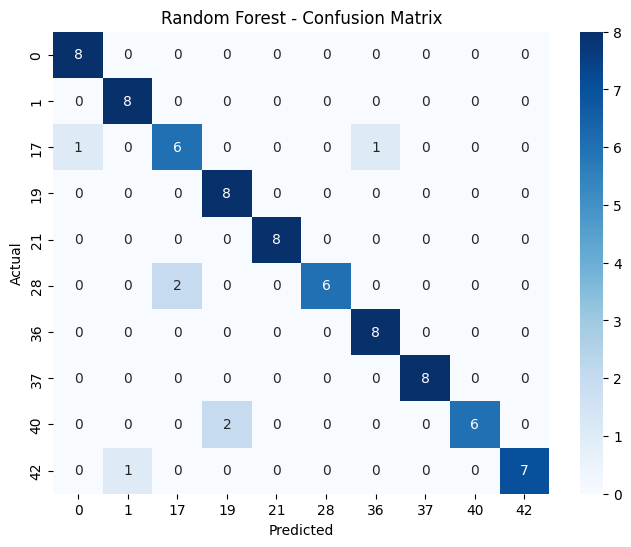

In [35]:
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Classification report
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [36]:
rf_results = test_feature_combinations(
    combinations_dict=feature_combinations,  # Your feature dictionary
    y=y,  # Your corresponding labels
    model=RandomForestClassifier(),  # RF model
    model_name="Random Forest",  # Model name for display purposes
    model_params={  # Default RF parameters (if grid search is off)
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'random_state': 42
    },
    n_splits=5,  # Number of Stratified K-Folds
    normalize=False,  # Disable normalization of features
    apply_pca=False,  # Disable PCA here for testing; set to True if needed
    n_pca_components=10,  # Number of PCA components to apply if needed
    overfit_threshold=0.2,  # Threshold to detect overfitting
    use_gridsearch=False,  # Disable or enable GridSearch
    hyperparameter_grid={  # Grid is always passed, but used only when use_gridsearch=True
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    top_k_results=5,  # Display top 5 combinations
    verbose=True  # Enable detailed output for each combination
)


🔍 Testing 63 feature combinations for Random Forest...

Combination: ('mfcc',), AUC: 0.9600, Train Acc: 0.9984, Val Acc: 0.7375, Overfitting: ⚠️ Overfitting Risk
Combination: ('spectral',), AUC: 0.9717, Train Acc: 0.9992, Val Acc: 0.7656, Overfitting: ⚠️ Overfitting Risk
Combination: ('hist',), AUC: 0.9156, Train Acc: 0.9977, Val Acc: 0.5906, Overfitting: ⚠️ Overfitting Risk
Combination: ('zcr',), AUC: 0.8702, Train Acc: 0.9266, Val Acc: 0.4625, Overfitting: ⚠️ Overfitting Risk
Combination: ('envelope',), AUC: 0.8671, Train Acc: 0.9633, Val Acc: 0.4844, Overfitting: ⚠️ Overfitting Risk
Combination: ('hnr',), AUC: 0.7360, Train Acc: 0.7547, Val Acc: 0.2500, Overfitting: ⚠️ Overfitting Risk
Combination: ('mfcc', 'spectral'), AUC: 0.9842, Train Acc: 1.0000, Val Acc: 0.8313, Overfitting: ✅ No Overfitting
Combination: ('mfcc', 'hist'), AUC: 0.9693, Train Acc: 1.0000, Val Acc: 0.7875, Overfitting: ⚠️ Overfitting Risk
Combination: ('mfcc', 'zcr'), AUC: 0.9684, Train Acc: 0.9992, Val Acc: 0.7

In [37]:
feature_selection = {
    'mfcc': False,
    'hist': False,
    'spectral': True,
    'zcr': False,
    'envelope': False,
    'hnr': False
}
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)


Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ❌
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ❌
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)



Settings:
 - Selected Features: spectral
 - Model: RandomForestClassifier
 - Model Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'random_state': 42}

 - Preprocessing: {'normalize': False, 'apply_pca': False, 'n_pca_components': 10}


[Fold 1]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 20
   - Train Accuracy: 0.9969, Test Accuracy: 0.7500
   - AUC: 0.9835

[Fold 2]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 20
   - Train Accuracy: 1.0000, Test Accuracy: 0.8375
   - AUC: 0.9917

[Fold 3]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 20
   - Train Accuracy: 1.0000, Test Accuracy: 0.7250
   - AUC: 0.9762

[Fold 4]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 20
   - Train Accuracy: 1.0000, Test Accuracy: 0.7750
   - AUC: 0.9667

[Fold 5]
   - Training set size: 320, Test set 

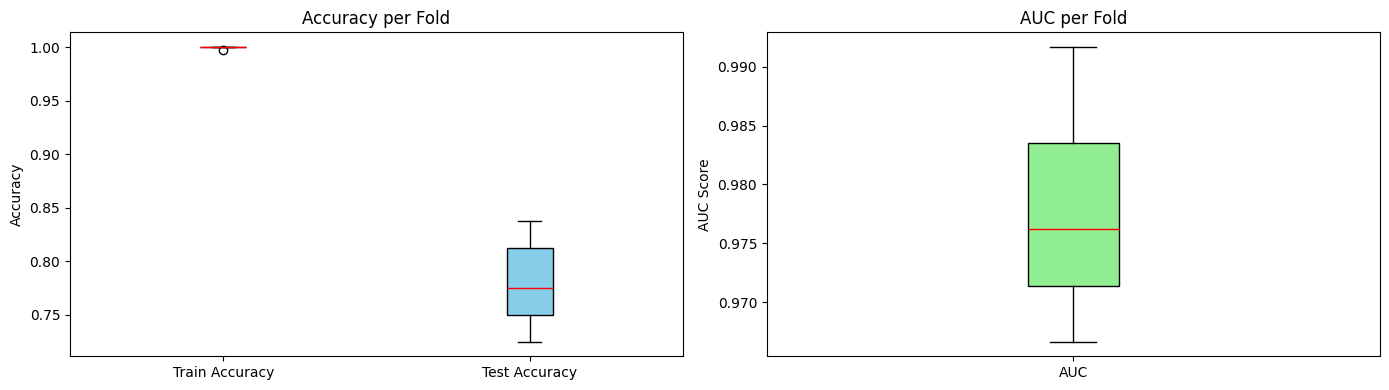


Classification Report (Last Fold):
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       1.00      0.88      0.93         8
          17       0.75      0.75      0.75         8
          19       0.80      1.00      0.89         8
          21       0.86      0.75      0.80         8
          28       0.86      0.75      0.80         8
          36       0.83      0.62      0.71         8
          37       0.88      0.88      0.88         8
          40       0.86      0.75      0.80         8
          42       1.00      1.00      1.00         8

    accuracy                           0.81        80
   macro avg       0.83      0.81      0.82        80
weighted avg       0.83      0.81      0.82        80



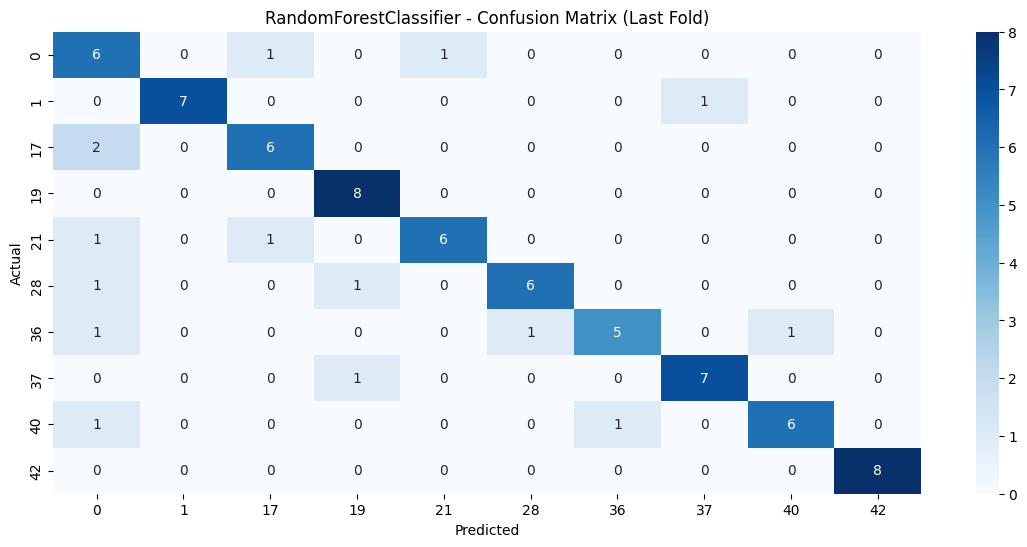

In [38]:
rf_results = kfold_cross_validation(
    features=selected_features,
    labels=y,
    selected_features_names=selected_features_names,
    model=RandomForestClassifier(),
    model_params={
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 5,
        'random_state': 42
    },
    n_splits=5,
    preprocess_params={'normalize': False, 'apply_pca': False, 'n_pca_components': 10},
    overfit_threshold=0.15
)

---
---

# KNN

In [39]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (set True to include, False to exclude)
feature_selection = {
    'mfcc': True,
    'hist': True,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

X_train, X_test = preprocess_features(
    X_train, X_test, normalize=True, apply_pca=False, n_pca_components=0.9, verbose=True
)


Combined feature shape: (400, 134)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)
✅ Normalization applied.
❌ PCA skipped.



KNN Test Accuracy: 0.7000
KNN Test AUC: 0.9062

KNN Training Accuracy: 0.8719

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.78      0.88      0.82         8
          17       0.67      0.75      0.71         8
          19       0.67      1.00      0.80         8
          21       0.62      1.00      0.76         8
          28       0.45      0.62      0.53         8
          36       1.00      0.75      0.86         8
          37       1.00      0.50      0.67         8
          40       1.00      0.38      0.55         8
          42       0.83      0.62      0.71         8

    accuracy                           0.70        80
   macro avg       0.76      0.70      0.69        80
weighted avg       0.76      0.70      0.69        80



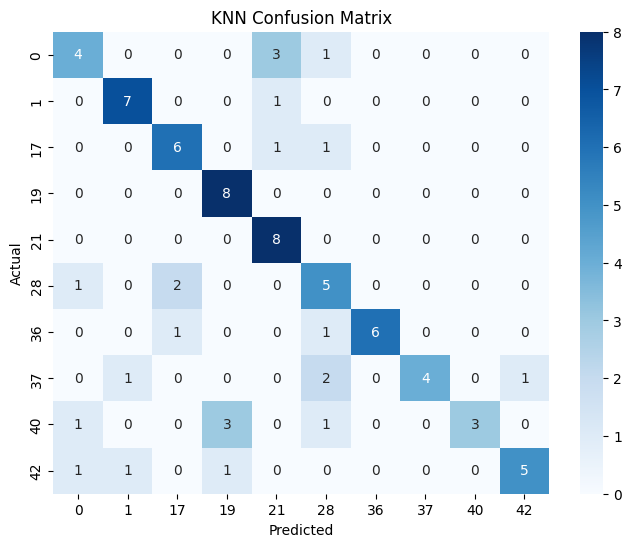

In [40]:
# Initialize the KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predictions on test set
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

# Evaluation
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# Predictions on train set for training accuracy
y_train_pred = knn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print evaluation metrics
print(f"\nKNN Test Accuracy: {test_accuracy:.4f}")
print(f"KNN Test AUC: {test_auc:.4f}")
print(f"\nKNN Training Accuracy: {train_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

In [41]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn, best_params_knn, best_score_knn = grid_search_hyperparameter_tuning(
    model=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    X_train=X_train,
    y_train=y_train
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best roc_auc_ovr Score: 0.9609


In [42]:
def test_feature_combinations(
    combinations_dict,
    y,
    model,
    model_name,
    model_params=None,
    n_splits=5,
    normalize=True,
    apply_pca=True,
    n_pca_components=0.9,
    overfit_threshold=0.1,
    hyperparameter_grid=None,
    use_gridsearch=False,
    top_k_results=5,
    verbose=False
):
    results = []

    # Generate all possible non-empty combinations of features
    all_combinations = [comb for i in range(1, len(combinations_dict) + 1) 
                        for comb in itertools.combinations(combinations_dict.keys(), i)]

    print(f"\n🔍 Testing {len(all_combinations)} feature combinations for {model_name}...\n")

    for combination in all_combinations:
        # Select features
        selected_features = np.hstack([combinations_dict[feature] for feature in combination])

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            selected_features, y, test_size=0.2, random_state=42, stratify=y
        )

        # Preprocess features (Normalize, PCA if applicable)
        X_train, X_test = preprocess_features(
            X_train, X_test, 
            normalize=normalize, 
            apply_pca=apply_pca, 
            n_pca_components=n_pca_components,
            verbose=False  # Silence preprocessing output during the loop
        )

        # Optionally perform GridSearch
        if use_gridsearch:
            if hyperparameter_grid:
                print(f"\nPerforming grid search for combination: {combination}...")
                grid_search, best_params, best_score = grid_search_hyperparameter_tuning(
                    model=model,
                    param_grid=hyperparameter_grid,
                    X_train=X_train,
                    y_train=y_train
                )
                model_params = best_params
                print(f"Grid search complete. Best parameters: {best_params}, Best AUC: {best_score:.4f}")
            else:
                raise ValueError("Grid search enabled, but no hyperparameter grid provided.")
        elif not model_params:
            raise ValueError("Provide `model_params` or enable grid search.")

        # Cross-validation using K-Fold
        train_accuracies, val_accuracies, auc_scores = [], [], []
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, val_idx in kfold.split(X_train, y_train):
            fold_X_train, fold_X_val = X_train[train_idx], X_train[val_idx]
            fold_y_train, fold_y_val = y_train[train_idx], y_train[val_idx]

            # Initialize and train the model
            classifier = model.set_params(**model_params)
            classifier.fit(fold_X_train, fold_y_train)

            # Training and validation accuracy
            train_acc = accuracy_score(fold_y_train, classifier.predict(fold_X_train))
            val_acc = accuracy_score(fold_y_val, classifier.predict(fold_X_val))
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            # Calculate AUC if available
            if hasattr(classifier, "predict_proba"):
                y_val_proba = classifier.predict_proba(fold_X_val)
                auc_scores.append(roc_auc_score(fold_y_val, y_val_proba, multi_class='ovr'))

        # Calculate averages
        avg_train_accuracy = np.mean(train_accuracies)
        avg_val_accuracy = np.mean(val_accuracies)
        avg_auc = np.mean(auc_scores) if auc_scores else None
        overfitting_gap = avg_train_accuracy - avg_val_accuracy
        overfitting_status = "⚠️ Overfitting Risk" if overfitting_gap > overfit_threshold else "✅ No Overfitting"

        # Calculate combined score: 50% AUC + 50% validation accuracy
        combined_score = 0.5 * (avg_auc if avg_auc is not None else 0) + 0.5 * avg_val_accuracy

        # Store results
        results.append({
            'combination': combination,
            'average_auc': avg_auc,
            'average_train_accuracy': avg_train_accuracy,
            'average_val_accuracy': avg_val_accuracy,
            'combined_score': combined_score,
            'overfitting_status': overfitting_status,
            'overfitting_gap': overfitting_gap
        })

        if verbose:
            print(f"Combination: {combination}, "
                  f"AUC: {f'{avg_auc:.4f}' if avg_auc is not None else 'N/A'}, "
                  f"Train Acc: {avg_train_accuracy:.4f}, "
                  f"Val Acc: {avg_val_accuracy:.4f}, "
                  f"Overfitting: {overfitting_status}")

    # Filter and sort by combined score
    sorted_results = sorted(results, key=lambda x: x['combined_score'], reverse=True)

    # Display top-k results
    print(f"\n📊 Top {top_k_results} Results (sorted by Combined Score):")
    for i, res in enumerate(sorted_results[:top_k_results], start=1):
        print(f"  {i}. Combination: {res['combination']}, "
              f"Combined Score: {res['combined_score']:.4f}, "
              f"Test Acc: {res['average_val_accuracy']:.4f}, "
              f"Train Acc: {res['average_train_accuracy']:.4f}, "
              f"AUC: {f'{res['average_auc']:.4f}' if res['average_auc'] is not None else 'N/A'}, "
              f"Train-Test Gap: {res['overfitting_gap']:.4f}, "
              f"Overfitting Status: {res['overfitting_status']}")

    return sorted_results

In [43]:
knn_results = test_feature_combinations(
    combinations_dict=feature_combinations,  # Your feature dictionary
    y=y,  # Your corresponding labels
    model=KNeighborsClassifier(),  # KNN model
    model_name="KNN",  # Model name for display purposes
    model_params={
        'n_neighbors': 7,
        'weights': 'uniform',
        'metric': 'euclidean'
    },  # KNN parameters
    n_splits=5,  # Number of Stratified K-Folds
    normalize=True,  # Enable normalization of features
    apply_pca=False,  # Disable PCA for now
    n_pca_components=10,  # Number of PCA components if apply_pca=True
    overfit_threshold=0.1,  # Threshold to detect overfitting
    use_gridsearch=False,  # Disable grid search in this example
    top_k_results=5,  # Show top 5 combinations
    verbose=True  # printing all combinations during the loop
)


🔍 Testing 63 feature combinations for KNN...

Combination: ('mfcc',), AUC: 0.8938, Train Acc: 0.6727, Val Acc: 0.5687, Overfitting: ⚠️ Overfitting Risk
Combination: ('spectral',), AUC: 0.9432, Train Acc: 0.7930, Val Acc: 0.6656, Overfitting: ⚠️ Overfitting Risk
Combination: ('hist',), AUC: 0.8345, Train Acc: 0.5828, Val Acc: 0.4469, Overfitting: ⚠️ Overfitting Risk
Combination: ('zcr',), AUC: 0.8276, Train Acc: 0.5758, Val Acc: 0.4781, Overfitting: ✅ No Overfitting
Combination: ('envelope',), AUC: 0.8189, Train Acc: 0.5437, Val Acc: 0.4031, Overfitting: ⚠️ Overfitting Risk
Combination: ('hnr',), AUC: 0.7046, Train Acc: 0.4250, Val Acc: 0.2500, Overfitting: ⚠️ Overfitting Risk
Combination: ('mfcc', 'spectral'), AUC: 0.9432, Train Acc: 0.7922, Val Acc: 0.7063, Overfitting: ✅ No Overfitting
Combination: ('mfcc', 'hist'), AUC: 0.8803, Train Acc: 0.6398, Val Acc: 0.5125, Overfitting: ⚠️ Overfitting Risk
Combination: ('mfcc', 'zcr'), AUC: 0.9008, Train Acc: 0.6945, Val Acc: 0.5844, Overfitt

In [44]:
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': False,
    'envelope': True,
    'hnr': True
}

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

X_train, X_test = preprocess_features(
    X_train, X_test, normalize=True, apply_pca=False, n_pca_components=0.9
)

Combined feature shape: (400, 52)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 52)
✅ Normalization applied.
❌ PCA skipped.



KNN Test Accuracy: 0.7375
KNN Test AUC: 0.9617

KNN Training Accuracy: 0.8094

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.73      1.00      0.84         8
          17       0.60      0.38      0.46         8
          19       0.73      1.00      0.84         8
          21       0.57      1.00      0.73         8
          28       0.83      0.62      0.71         8
          36       0.78      0.88      0.82         8
          37       1.00      0.50      0.67         8
          40       0.71      0.62      0.67         8
          42       1.00      0.62      0.77         8

    accuracy                           0.74        80
   macro avg       0.77      0.74      0.73        80
weighted avg       0.77      0.74      0.73        80



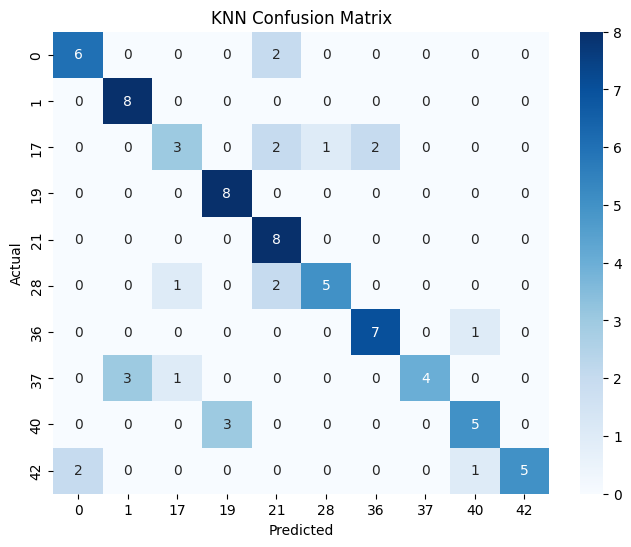

In [45]:
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# Predictions on test set
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)

# Evaluation
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# Predictions on train set for training accuracy
y_train_pred = knn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print evaluation metrics
print(f"\nKNN Test Accuracy: {test_accuracy:.4f}")
print(f"KNN Test AUC: {test_auc:.4f}")
print(f"\nKNN Training Accuracy: {train_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

In [46]:
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': False,
    'envelope': True,
    'hnr': True
}

# selected_features, selected_features_names = get_selected_features(feature_combinations, feature_selection)

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

Combined feature shape: (400, 52)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 52)



Settings:
 - Selected Features: mfcc, spectral, envelope, hnr
 - Model: KNeighborsClassifier
 - Model Parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}

 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.8}


[Fold 1]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 52
   - Train Accuracy: 0.8156, Test Accuracy: 0.7875
   - AUC: 0.9619

[Fold 2]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 52
   - Train Accuracy: 0.8156, Test Accuracy: 0.8375
   - AUC: 0.9676

[Fold 3]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 52
   - Train Accuracy: 0.8000, Test Accuracy: 0.7000
   - AUC: 0.9733

[Fold 4]
   - Training set size: 320, Test set size: 80
   - Feature dimension after preprocessing: 52
   - Train Accuracy: 0.8406, Test Accuracy: 0.7125
   - AUC: 0.9476

[Fold 5]
   - Training set size: 320, Test set 

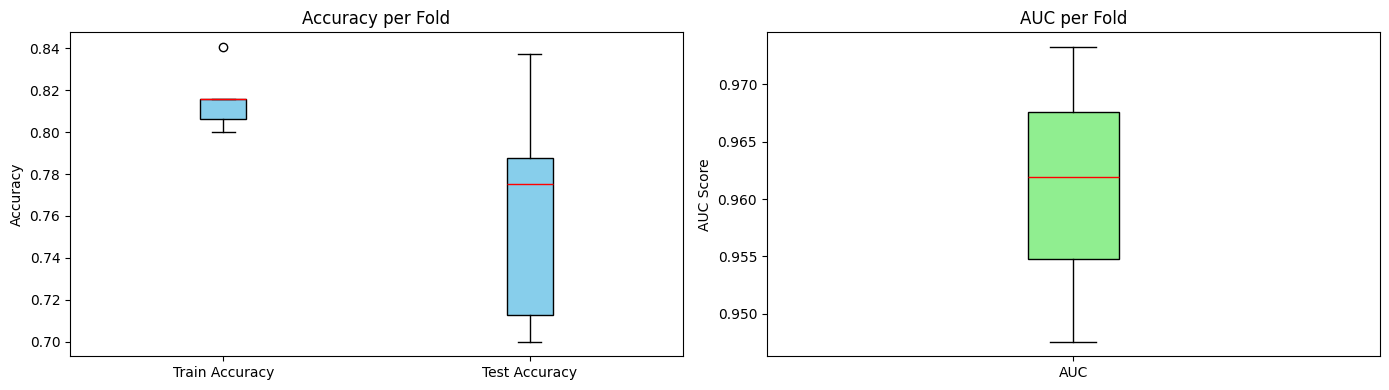


Classification Report (Last Fold):
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.80      1.00      0.89         8
          17       1.00      0.75      0.86         8
          19       0.62      1.00      0.76         8
          21       0.62      1.00      0.76         8
          28       0.88      0.88      0.88         8
          36       0.70      0.88      0.78         8
          37       1.00      0.50      0.67         8
          40       0.86      0.75      0.80         8
          42       1.00      0.50      0.67         8

    accuracy                           0.78        80
   macro avg       0.83      0.78      0.77        80
weighted avg       0.83      0.78      0.77        80



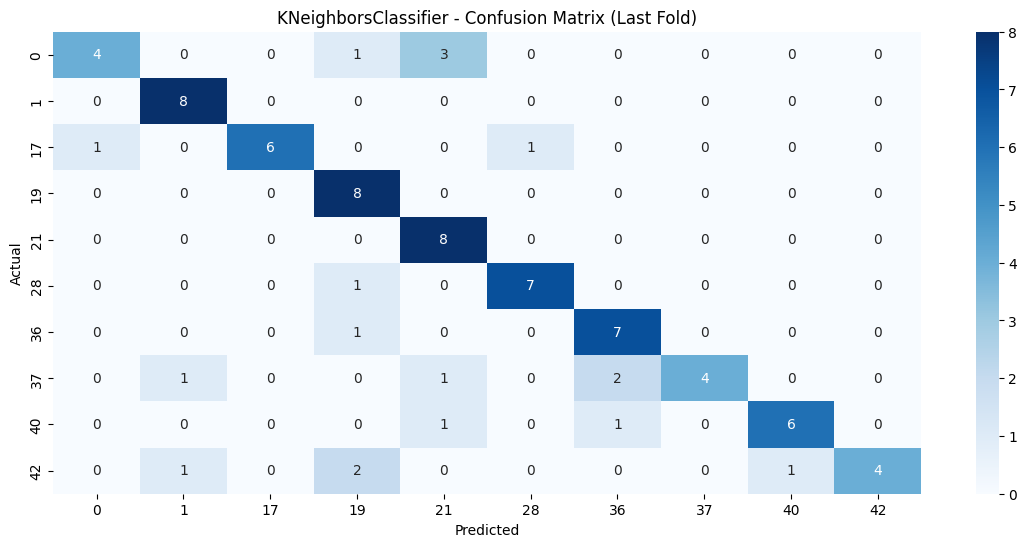

In [47]:
knn_results = kfold_cross_validation(
    features=selected_features,
    labels=y,
    selected_features_names=selected_features_names,
    model=KNeighborsClassifier(),  # Initialize the KNN model
    model_params={
        'n_neighbors': 7,
        'weights': 'uniform',
        'metric': 'euclidean'
    },
    n_splits=5,
    preprocess_params={'normalize': True, 'apply_pca': False, 'n_pca_components': 0.8},
    overfit_threshold=0.15
)

---
---

# K-Means

In [50]:
from scipy.stats import mode

# 1️⃣ Step 1: Feature Selection
feature_selection = {
    'mfcc': True,
    'hist': False,
    'spectral': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Load selected features
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

# 2️⃣ Step 2: Normalize the Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use the same scaler for the test set



Combined feature shape: (400, 54)
Feature shapes and selection status:
Mfcc shape: (400, 26) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral shape: (400, 20) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 54)


Number of PCA Components Used: 34
Explained Variance: 0.954231627903562


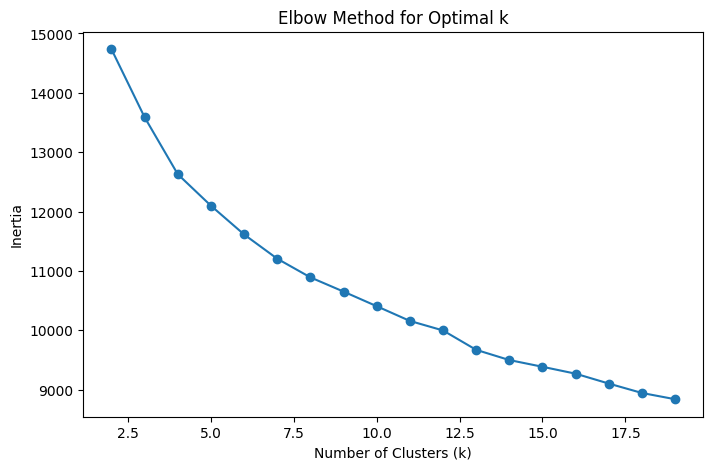

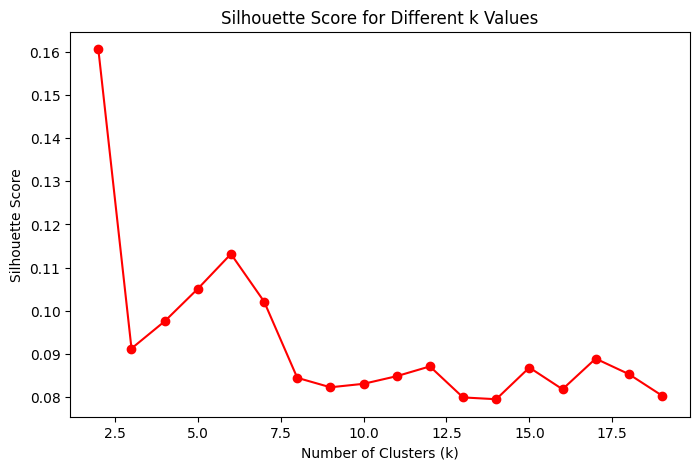

Silhouette Score for k=10: 0.0831


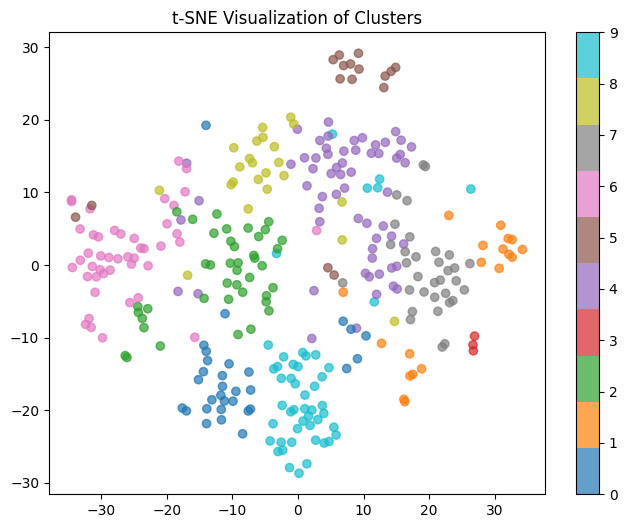

Adjusted Rand Index (ARI) for K-Means: 0.4197


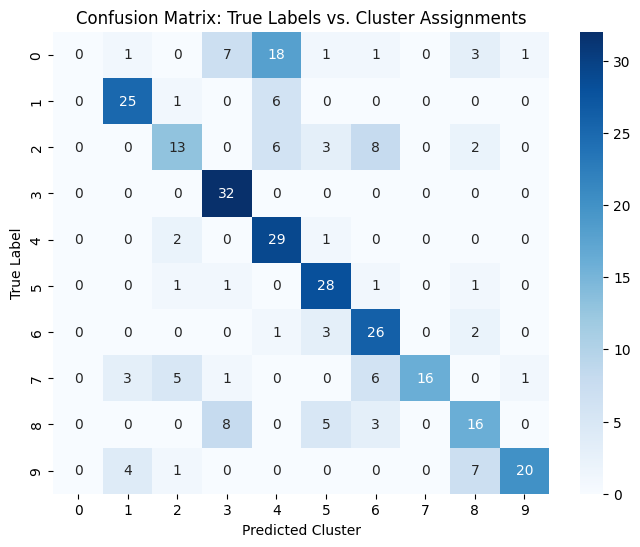

In [51]:
# 3️⃣ Step 3: Apply PCA for Dimensionality Reduction
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components Used:", pca.n_components_)
print("Explained Variance:", np.sum(pca.explained_variance_ratio_))

# 4️⃣ Step 4: Find the Optimal Number of Clusters using the Elbow Method
inertia = []
sil_scores = []  # ✅ FIXED: Define silhouette scores list

K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_train_pca)
    
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_train_pca, labels))  # ✅ FIXED: Compute Silhouette Score

# ✅ Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# ✅ Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o', label='Silhouette Score', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k Values")
plt.show()

# 5️⃣ Step 5: Perform K-Means Clustering with k=10 (Known Value)
best_k = 10  # Since we already know the correct number of clusters

#kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=20, max_iter=5000) 
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=30)
cluster_labels = kmeans.fit_predict(X_train_pca)

# 6️⃣ Step 6: Evaluate Clustering Performance using Silhouette Score
silhouette = silhouette_score(X_train_pca, cluster_labels)
print(f"Silhouette Score for k=10: {silhouette:.4f}")

# 7️⃣ Step 7: Visualize Clusters using t-SNE
X_embedded = TSNE(n_components=2, perplexity=15, random_state=42).fit_transform(X_train_pca)  # ✅ FIXED Perplexity

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of Clusters")
plt.show()

# 8️⃣ Step 8: Evaluate K-Means with Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(y_train, cluster_labels)
print(f"Adjusted Rand Index (ARI) for K-Means: {ari_score:.4f}")


# 🔟 Step 9: Assign Labels to Clusters using Majority Voting
def assign_labels_majority(y_true, cluster_labels):
    assigned_labels = np.zeros_like(cluster_labels)

    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        true_labels = y_true[mask]  # Get true labels in this cluster
        
        if len(true_labels) == 0:  # Edge case: No data points in cluster
            continue 
        
        if len(true_labels) > 0:
            majority_label = mode(true_labels, keepdims=True).mode[0]
        else:
            majority_label = -1  # Assign an unused label if cluster is empty

        
        assigned_labels[mask] = majority_label  # Assign majority label to all cluster members

    return assigned_labels

y_pred = assign_labels_majority(y_train, cluster_labels)

# 1️⃣1️⃣ Step 11: Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix: True Labels vs. Cluster Assignments')
plt.show()


In [52]:
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

print("\n🔍 Cluster Size Distribution:")
for cluster, count in sorted(cluster_distribution.items()):
    print(f"Cluster {cluster}: {count} samples")



🔍 Cluster Size Distribution:
Cluster 0: 31 samples
Cluster 1: 19 samples
Cluster 2: 41 samples
Cluster 3: 3 samples
Cluster 4: 60 samples
Cluster 5: 16 samples
Cluster 6: 45 samples
Cluster 7: 33 samples
Cluster 8: 23 samples
Cluster 9: 49 samples


In [53]:
for cluster in np.unique(cluster_labels):
    assigned_class = mode(y_train[cluster_labels == cluster], keepdims=True).mode[0]
    print(f"Cluster {cluster} is mostly class {assigned_class}")


Cluster 0 is mostly class 40
Cluster 1 is mostly class 42
Cluster 2 is mostly class 28
Cluster 3 is mostly class 42
Cluster 4 is mostly class 21
Cluster 5 is mostly class 37
Cluster 6 is mostly class 36
Cluster 7 is mostly class 1
Cluster 8 is mostly class 17
Cluster 9 is mostly class 19


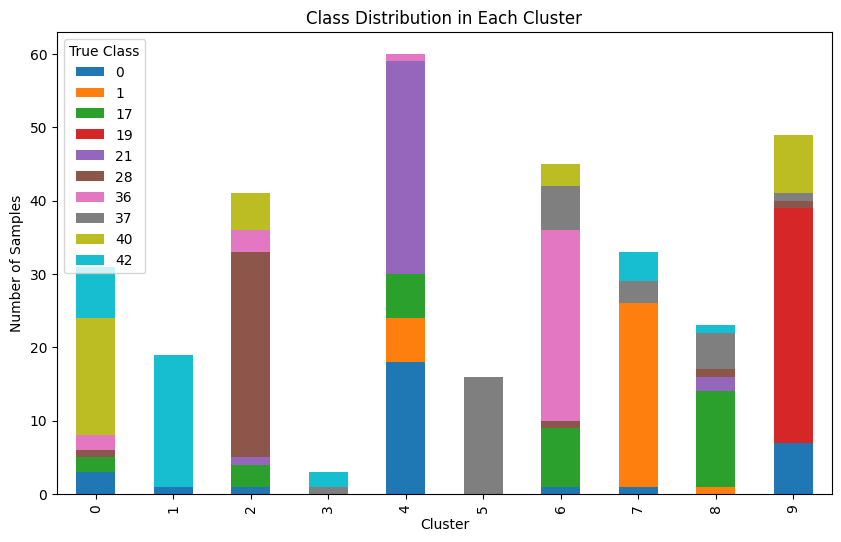

In [54]:
cluster_class_df = pd.DataFrame({'Cluster': cluster_labels, 'True Class': y_train})
cluster_counts = cluster_class_df.groupby(['Cluster', 'True Class']).size().unstack(fill_value=0)

cluster_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab10')
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Each Cluster")
plt.legend(title="True Class")
plt.show()
